# Program Overview

The purpose of this notebook is to analyze monthly article traffic from English Wikipedia articles published 07-01-2015 through 09-30-2023. Specifically, we will be producing graphs for articles with the:
    Highest and lowest average monthly view rates for both desktop and mobile
    Top 10 peak page views for both desktop and mobile access
    Fewest months of data for recent award winners on both mobile and desktop

The source data uses the following license:
**EKRC INSERT LICENSE HERE

We begin by loading common python libraries. Note, the plotly visualization saving requires kaleido, which the user may need to install.

In [2]:
#Import python libraries
import json
from datetime import datetime
import urllib.parse
import requests
import pandas as pd
import plotly.express as px
import seaborn as sns

Uploading the mobile and desktop files we will use to analyze the data as dictionaries.

In [ ]:
#Loading in desktop and mobile files
mobile_file = open("../clean_data/academy_monthly_mobile_201507-202309.json")
desktop_file = open("../clean_data/academy_monthly_desktop_201507-202309.json")

#Turn files into dicts
mobile_dict = json.load(mobile_file)
desktop_dict = json.load(desktop_file)

### Maximum Average and Minimum Average

The following sections of code will find the max and min average pageviews per month for mobile and desktop articles. Given we must repeat the process on both desktop and mobile articles we create a function which can be reused to generate a list of article titles and a separate list of average monthly pageviews. By identifying the max and min pageviews' indices, one can also find the articles with the max and min pageviews respectively.

In [4]:
#Creating function to return article name w/ max average monthly pageviews
#and article name with min monthly pageviews

def min_max_articles(dict_file):
    #Finding the average pageviews per month & adding to list
    article_list = list(dict_file.keys())
    avg_monthly_views = []
    for key in article_list:
        num_months = 0
        tot_views = 0
        for month in dict_file[key]:
            num_months = num_months + 1
            tot_views = tot_views + month['views']
        avg_monthly_views.append(tot_views/num_months)
    #Getting the index of the max and min pageviews
    min_views = min(avg_monthly_views)
    max_views = max(avg_monthly_views)
    min_index = avg_monthly_views.index(min_views)
    max_index = avg_monthly_views.index(max_views)
    #Getting the name of the max and min articles
    min_article = article_list[min_index]
    max_article = article_list[max_index]
    return min_article, max_article

#Use the following line to test if the method is working
#min_name, max_name= min_max_articles(mobile_dict)
#print(min_name, max_name)

Next, we will create a function to return a dataframe with the timeseries data for the articles with the min and max monthly views from a single datasource.

In [5]:
#Creating function to return timeseries information with monthly pageviews
#for min and max avg. pageviews articles

def min_max_timeseries(dict_file, min_name, max_name, access_format):
    timeseries_list = []
    for month in dict_file[min_name]:        
        raw_time = month['timestamp']
        format_time = datetime.strptime(raw_time, '%Y%m%d%H').strftime('%Y-%m')
        timeseries_list.append([min_name,"min "+access_format,
                             format_time, month['views']])
    for month in dict_file[max_name]:
        raw_time = month['timestamp']
        format_time = datetime.strptime(raw_time, '%Y%m%d%H').strftime('%Y-%m')
        timeseries_list.append([max_name,"max "+access_format,
                             format_time, month['views']])
    timeseries_df = pd.DataFrame(timeseries_list)
    timeseries_df.columns = ['article_title', 'kind', 'date', 'pageviews']
    return timeseries_df

#Use the following line to test if the method is working
'''mobile_df = min_max_timeseries(mobile_dict, min_name, max_name, "mobile")
mobile_df'''

'mobile_df = min_max_timeseries(mobile_dict, min_name, max_name, "mobile")\nmobile_df'

Now that we've created the two fuctions above, we will use them to pull the min and max names from the desktop and mobile datasources respectively. We will then use those names to generate two dataframes with timeseries data, and combine the data into a single timeseries for later graphing.

In [6]:
#Pulling desktop and mobile info
min_desktop_name, max_desktop_name = min_max_articles(desktop_dict)
#print(min_desktop_name, max_desktop_name)
min_mobile_name, max_mobile_name = min_max_articles(mobile_dict)
#print(min_mobile_name, max_mobile_name)

#Generating dataframes with min and max desktop and mobile data respectively
desktop_df = min_max_timeseries(desktop_dict, min_desktop_name, max_desktop_name, "desktop")
mobile_df = min_max_timeseries(mobile_dict, min_mobile_name, max_mobile_name, "mobile")

#Combining the dataframes together
df_list = [desktop_df, mobile_df]
min_max_avg_df = pd.concat(df_list)
#min_max_avg_df

To make it clearer in our legend which article title represents which max/min desktop/mobile article, we are creating a "legend" column which combines the article name with its kind (e.g., max mobile).

In [7]:
#Combining cols into new col
min_max_avg_df['legend'] = min_max_avg_df['article_title']+" ("+min_max_avg_df['kind']+")"
#min_max_avg_df

Now we will graph the timeseries data for the min and max desktop and mobile article views. We will use the Seaborn library with each article title as a line and its pageviews over time.

In [8]:
'''#Creating Seaborn plot of multi-line timeseries
fig = px.line(min_max_avg_df, x = 'date', y = 'pageviews', color = 'legend',
             labels = {
                 'date': 'Date',
                 'pageviews': "Total Monthly Pageviews",
                 'legend': "Legend"
             },
             title = "Articles with Min and Max Avg. Monthly Pageviews on Desktop and Mobile")
fig.update_layout(font_size = 8,
                    title=dict(font=dict(size=12)))
fig.show()
fig.write_image('../results/min_avg_max_avg.jpeg', format = 'jpeg',
                engine = 'kaleido')'''

'#Creating Seaborn plot of multi-line timeseries\nfig = px.line(min_max_avg_df, x = \'date\', y = \'pageviews\', color = \'legend\',\n             labels = {\n                 \'date\': \'Date\',\n                 \'pageviews\': "Total Monthly Pageviews",\n                 \'legend\': "Legend"\n             },\n             title = "Articles with Min and Max Avg. Monthly Pageviews on Desktop and Mobile")\nfig.update_layout(font_size = 8,\n                    title=dict(font=dict(size=12)))\nfig.show()\nfig.write_image(\'../results/min_avg_max_avg.jpeg\', format = \'jpeg\',\n                engine = \'kaleido\')'

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

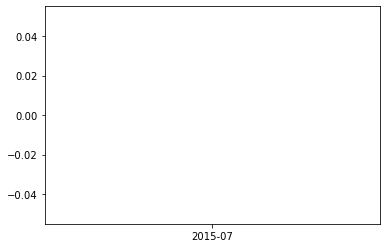

In [11]:
#Graphing in Seaborn instead of plotly
sns.lineplot(data = min_max_avg_df, x = 'date', y = 'pageviews',
             hue = 'legend')

In [10]:
min_max_avg_df

,article_title,kind,date,pageviews,legend
0,Project Hope (film),min desktop,2015-07,56,Project Hope (film) (min desktop)
1,Project Hope (film),min desktop,2015-08,31,Project Hope (film) (min desktop)
2,Project Hope (film),min desktop,2015-09,60,Project Hope (film) (min desktop)
3,Project Hope (film),min desktop,2015-10,56,Project Hope (film) (min desktop)
4,Project Hope (film),min desktop,2015-11,40,Project Hope (film) (min desktop)
...,...,...,...,...,...
109,The Whale (2022 film),max mobile,2023-05,194589,The Whale (2022 film) (max mobile)
110,The Whale (2022 film),max mobile,2023-06,210556,The Whale (2022 film) (max mobile)
111,The Whale (2022 film),max mobile,2023-07,167920,The Whale (2022 film) (max mobile)
112,The Whale (2022 film),max mobile,2023-08,192969,The Whale (2022 film) (max mobile)


### Top 10 Peak Page Views

In the following sections of code we will create a graph with a time series containing the top 10 articles by largest peak page views by access type. We will begin by writing a function which finds and returns the top 10 peak pageviews for articles in a file.

In [36]:
#Identifying max page views for each article
def max_views_builder(dict_file, access_type):
    #finding the peak pageviews for each article in a file w/ specified 
    #access type
    max_views_list = []
    article_list = list(dict_file.keys())
    for key in article_list:
        max_views = 0
        for month in dict_file[key]:
            if month['views'] > max_views:
                max_views = month['views']
        max_views_list.append([key, max_views, access_type])
    max_views_df = pd.DataFrame(max_views_list)
    max_views_df.columns = ['article_title', 'max_pageviews', access_type]
    #Sorting by peak pageviews and returning the top 10 results
    sort_max_views_df = max_views_df.sort_values('max_pageviews',
                                                 ascending = False).reset_index()
    top_10_max_views_df = sort_max_views_df[:10]
    return top_10_max_views_df

#Uncomment the following lines of code to visually verify the results of the
#above method
#print(max_views_builder(mobile_dict, 'mobile'))
#print(max_views_builder(desktop_dict, 'desktop'))

   index                      article_title  max_pageviews  mobile
0      5           Avatar: The Way of Water        8106378  mobile
1     51                  Joker (2019 film)        8047344  mobile
2     62               Black Panther (film)        5503665  mobile
3     43               Parasite (2019 film)        5484956  mobile
4      4     Black Panther: Wakanda Forever        4634986  mobile
5     12                         RRR (film)        4114488  mobile
6     14                   Dune (2021 film)        3956760  mobile
7    107           The Revenant (2015 film)        3802421  mobile
8      3                  Top Gun: Maverick        3784632  mobile
9      0  Everything Everywhere All at Once        3597067  mobile
   index             article_title  max_pageviews  desktop
0     51         Joker (2019 film)        3355060  desktop
1     43      Parasite (2019 film)        2813357  desktop
2     62      Black Panther (film)        2659906  desktop
3    107  The Revenant (201

Next we will create a function which returns a dataframe with the timeseries data for a list of input files. We will ultimately use this function to return a dataframe with the timeseries data of the top 10 mobile and desktop article pageviews.

In [30]:
#Building timeseries df returner function
def timeseries_returner(file_list, dict_file, access_type):
    timeseries_list = []
    for file in file_list:
        for month in dict_file[file]:
            raw_time = month['timestamp']
            format_time = datetime.strptime(raw_time, '%Y%m%d%H').strftime('%Y-%m')
            timeseries_list.append([file, format_time, month['views'],
                                    access_type])
    timeseries_df = pd.DataFrame(timeseries_list)
    timeseries_df.columns = ['article_title', 'date', 'pageviews','kind' ]
    return timeseries_df

Now we will use the max_views_builder function to identify the top 10 articles by peak pageviews for desktop and mobile. Then we will feed those results into our timeseries_returner function to build two data frames with the top 10 articles' pageview information. Then, we will combine the two dataframes of information for graphing in the next block of code. We are using the mobile and desktop files uploaded in the beginning of this notebook.

In [35]:
#Getting mobile and desktop top 10 df
mobile_top_10_df = max_views_builder(mobile_dict, 'mobile')
desktop_top_10_df = max_views_builder(desktop_dict, 'desktop')

#Getting top 10 article titles for both access methods
mobile_top_10 = list(mobile_top_10_df['article_title'])
desktop_top_10 = list(desktop_top_10_df['article_title'])

#Inputting both top 10 informations into timeseries_returner to get monthly
#pageviews information
mobile_top_10_timeseries_df = timeseries_returner(mobile_top_10, mobile_dict,
                                                 'mobile')
desktop_top_10_timeseries_df = timeseries_returner(desktop_top_10, desktop_dict,
                                                 'desktop')

#Combining the two monthly views dfs
df_list = [mobile_top_10_timeseries_df, desktop_top_10_timeseries_df]
top_10_timeseries_df = pd.concat(df_list)
#top_10_timeseries_df

,article_title,date,pageviews,kind
0,Avatar: The Way of Water,2018-11,0,mobile
1,Avatar: The Way of Water,2018-12,0,mobile
2,Avatar: The Way of Water,2019-01,1,mobile
3,Avatar: The Way of Water,2019-02,2,mobile
4,Avatar: The Way of Water,2019-03,1,mobile
...,...,...,...,...
696,Blade Runner 2049,2023-05,69784,desktop
697,Blade Runner 2049,2023-06,67683,desktop
698,Blade Runner 2049,2023-07,92360,desktop
699,Blade Runner 2049,2023-08,79704,desktop


In [14]:
mobile_dict['Project Hope (film)']

[{'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)',
  'granularity': 'monthly',
  'timestamp': '2015070100',
  'agent': 'user',
  'views': 6},
 {'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)',
  'granularity': 'monthly',
  'timestamp': '2015080100',
  'agent': 'user',
  'views': 7},
 {'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)',
  'granularity': 'monthly',
  'timestamp': '2015090100',
  'agent': 'user',
  'views': 7},
 {'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)',
  'granularity': 'monthly',
  'timestamp': '2015100100',
  'agent': 'user',
  'views': 11},
 {'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)',
  'granularity': 'monthly',
  'timestamp': '2015110100',
  'agent': 'user',
  'views': 9},
 {'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)',
  'granularity': 'monthly',
  'timestamp': '2015120100',
  'agent': 'user',
  'views': 10},
 {'project': 'en.wikipedia',
  'article': 'Project_Hope_(film)